In [1]:
#We assume caterpillar dataset is already downloaded, if not look at 
#U2S3M1 notes

In [29]:
import pandas as pd
import numpy as np

trainval = pd.read_csv('competition_data/train_set.csv')
test     = pd.read_csv('competition_data/test_set.csv')

In [14]:
trainval.head(10)

,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity,cost
0,TA-00002,S-0066,2013-07-07,0,0,Yes,1,21.905933
1,TA-00002,S-0066,2013-07-07,0,0,Yes,2,12.341214
2,TA-00002,S-0066,2013-07-07,0,0,Yes,5,6.601826
3,TA-00002,S-0066,2013-07-07,0,0,Yes,10,4.687770
4,TA-00002,S-0066,2013-07-07,0,0,Yes,25,3.541561
5,TA-00002,S-0066,2013-07-07,0,0,Yes,50,3.224406
6,TA-00002,S-0066,2013-07-07,0,0,Yes,100,3.082521
7,TA-00002,S-0066,2013-07-07,0,0,Yes,250,2.999060
8,TA-00004,S-0066,2013-07-07,0,0,Yes,1,21.972702
9,TA-00004,S-0066,2013-07-07,0,0,Yes,2,12.407983


In [15]:
test.head(10)

,id,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity
0,1,TA-00001,S-0066,2013-06-23,0,0,Yes,1
1,2,TA-00001,S-0066,2013-06-23,0,0,Yes,2
2,3,TA-00001,S-0066,2013-06-23,0,0,Yes,5
3,4,TA-00001,S-0066,2013-06-23,0,0,Yes,10
4,5,TA-00001,S-0066,2013-06-23,0,0,Yes,25
5,6,TA-00001,S-0066,2013-06-23,0,0,Yes,50
6,7,TA-00001,S-0066,2013-06-23,0,0,Yes,100
7,8,TA-00001,S-0066,2013-06-23,0,0,Yes,250
8,9,TA-00003,S-0066,2013-07-07,0,0,Yes,1
9,10,TA-00003,S-0066,2013-07-07,0,0,Yes,2


In [16]:
# Need to change quote_date type
trainval.dtypes

tube_assembly_id       object
supplier               object
quote_date             object
annual_usage            int64
min_order_quantity      int64
bracket_pricing        object
quantity                int64
cost                  float64
dtype: object

In [7]:
trainval['quote_date'] = pd.to_datetime(trainval['quote_date'], infer_datetime_format=True)
test['quote_date'] = pd.to_datetime(test['quote_date'], infer_datetime_format = True)

In [22]:
trainval_tube_assemblies = trainval['tube_assembly_id'].unique()
test_tube_assemblies = test['tube_assembly_id'].unique()

#notice these sets sets are exclusive
set(trainval_tube_assemblies) & set(test_tube_assemblies)

set()

In [21]:
trainval_tube_assemblies

array(['TA-00002', 'TA-00004', 'TA-00005', ..., 'TA-21195', 'TA-21196',
       'TA-21197'], dtype=object)

In [24]:
# Separate train and val assembly id's according to same tube 
#   assembly id
from sklearn.model_selection import train_test_split
train_tube_assemblies, val_tube_assemblies = train_test_split(
    trainval_tube_assemblies, random_state=42
)

In [27]:
#Now insert the splitted id's to train and val data
train = trainval[trainval['tube_assembly_id'].isin(train_tube_assemblies)]
val   = trainval[trainval['tube_assembly_id'].isin(val_tube_assemblies)]

train.shape, val.shape, trainval.shape

((22628, 8), (7585, 8), (30213, 8))

In [33]:
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import r2_score

def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true,y_pred))

In [36]:
#Baseline Score
target = 'cost' 
y_train = train[target]
y_val = val[target]
y_pred = np.full_like(y_val, fill_value=y_train.mean())
print('Validation RMSLE, Mean Baseline:', rmsle(y_val, y_pred))
print('Validation R^2, Mean Baseline:', r2_score(y_val,y_pred))

Validation RMSLE, Mean Baseline: 0.9418101276064408
Validation R^2, Mean Baseline: -4.701447715138585e-06


In [41]:
#Now try modeling on one feature
features = ['quantity']
X_train = train[features]
X_val = val[features]

In [45]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)
print(f'Validation RMSLE, Random Forest with {features}')
print(rmsle(y_val,y_pred))

r2 = model.score(X_val, y_val)
print('Validation R^2', r2)

Validation RMSLE, Random Forest with ['quantity']
0.6908805822519186
Validation R^2 0.08879518736792147


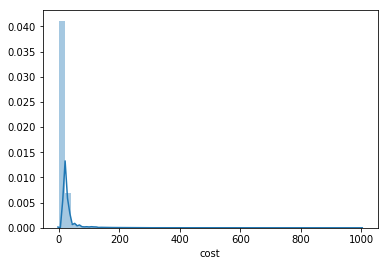

In [47]:
import seaborn as sns
sns.distplot(y_train);

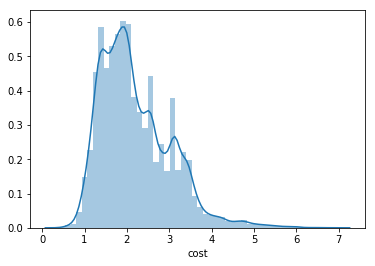

In [52]:
y_train_log = np.log1p(y_train)
sns.distplot(y_train_log);

In [53]:
#Refit model with log-transformed target, notice that rmsle imporves
# when model is trained on target feature that is more gaussian shaped 
model.fit(X_train, y_train_log)
y_pred_log = model.predict(X_val)
y_pred = np.expm1(y_pred_log)
rmsle(y_val, y_pred)

0.622925465880199

In [54]:
# Select more features

def wrangle(X):
    X = X.copy()
    
    # Engineer date features
    X['quote_date'] = pd.to_datetime(X['quote_date'], infer_datetime_format=True)
    X['quote_date_year'] = X['quote_date'].dt.year
    X['quote_date_month'] = X['quote_date'].dt.month
    X = X.drop(columns='quote_date')
    
    # Drop tube_assembly_id because our goal is to predict unknown assemblies
    X = X.drop(columns='tube_assembly_id')
    
    return X

train_wrangled = wrangle(train)
val_wrangled = wrangle(val)

In [55]:
features = train_wrangled.columns.drop(target)
print('Features:', features.tolist())

Features: ['supplier', 'annual_usage', 'min_order_quantity', 'bracket_pricing', 'quantity', 'quote_date_year', 'quote_date_month']


In [56]:
X_train = train_wrangled[features]
X_val = val_wrangled[features]

In [59]:
import category_encoders as ce
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
)

pipeline.fit(X_train, y_train_log);
#y_pred_log = pipeline.predict(X_val)
#rmse(y_val_log, y_pred_log)

In [60]:
# Now model gets rmsle even better

y_pred = np.expm1(y_pred_log)
rmsle(y_val, y_pred)

0.3950176959701

In [61]:
# See what feature was informative for model
rf = pipeline.named_steps['randomforestregressor']
importances = pd.Series(rf.feature_importances_, X_train.columns)

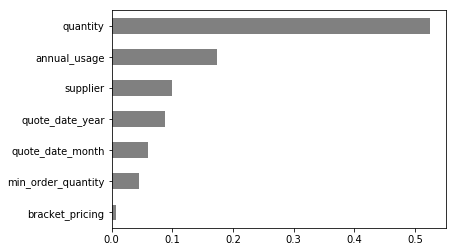

In [63]:
importances.sort_values().plot.barh(color="grey");

In [ ]:
# add more csv files: tube csv and add more merges to get around rmsle of .25